In [ ]:
# hide
import sys
sys.path.append("..")
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
#default_exp data

# Data

> Methods to load time series data from motion files

In [ ]:
# export
from fastcore.all import *
from timeseries.all import *
import pandas as pd
import numpy as np
from mlchaos.utils import df_slicer
import seaborn as sns

## Motions defined in files Poincare.plt and index.plt

We call an `item` as a pair `(fname_poincare, fname_index)`. From the Poincare file we get the data of the time series (the x or independent variable) and from the index file we get the y or dependent variable

### Load motion data from poincare file (independent variables)

In [ ]:
# export
def load_poincare_maps(fname):
    "Load the data from a Poincare map.\
    Returns a numpy array with a shape (n_orbits, 2, sequence_length). \
    The time column is removed from the data, since it is always multiples of 2*pi"
    df = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])
    seq_length = set(df.time).__len__()
    df = df.drop('time', axis=1)
    nparr = df_slicer(df, w=seq_length, s=seq_length)
    return nparr.transpose([0, 2, 1])

In [ ]:
fname = '~/data/Poincare.plt'
foo = load_poincare_maps(fname)
bar = pd.read_table(fname, sep='\s+', names=['time', 'x', 'y'])

In [ ]:
seq_len = set(bar.time).__len__()
test_eq(foo.shape[2], seq_len)

In [ ]:
test_eq(foo.shape[0], bar.shape[0]/seq_len)

In [ ]:
test_eq(foo[0,:,:], bar.drop('time', axis=1)[:seq_len].values.transpose(1,0))

### Load index of the motion from index file (dependent variable)

In [ ]:
# export
def load_index_file(fname):
    return pd.read_table(fname, 
                         sep='\s+', 
                         header=None, 
                         usecols=[7], 
                         squeeze=True).values

In [ ]:
fname = '~/data/index.plt'
foo = load_index_file(fname)

In [ ]:
test_eq(foo.__class__, np.ndarray)
test_eq(foo.shape.__len__(), 1)

### Load x and y at once from both the Poincare and the index file

In [ ]:
# export
def load_poincare_index_pair(fname_poincare, fname_index):
    "Load the x data from a Poincare file and the y data from the index file.\
    Returns a tuple of 2 numpy arrays: "
    "x : array with a shape (n_samples, n_channels, sequence_length)"
    "y : array with a shape (n_samples)"
    "for the Poincare maps, n_channels is 2 (x and y)"
    return load_poincare_maps(fname_poincare), load_index_file(fname_index)

In [ ]:
fname_poincare, fname_index = '~/data/Poincare.plt', '~/data/index.plt'
foo, bar = load_poincare_index_pair(fname_poincare, fname_index)

In [ ]:
test_eq(foo.__class__, np.ndarray)
test_eq(bar.__class__, np.ndarray)
test_eq(len(foo), len(bar))

### Create TSData object from a list of (Poincare.plt, index.plt) files

In [ ]:
# export
class TSDataChaos(TSData):
    @classmethod
    def from_poincare_and_index_files(cls, fnames):
        "`fnames` is a list of pairs (poincare_file, index_file), or a single pair."
        self = cls(fnames)
        self.x = []
        self.y = []
        self.dsname = []
        self.fnames = []
        xs,ys = [],[]
        if isinstance(fnames, list):
            for fn_poincare, fn_index in fnames:
                x, y = load_poincare_index_pair(fn_poincare, fn_index)
                xs.append(x)
                ys.append(y)
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(fn_poincare.parent.stem)
            self.x = np.concatenate(xs)
            self.y = np.concatenate(ys)
        else:
            fn_poincare, fn_index = fnames
            self.fnames.append(fnames)
            self.dsname.append(fn_poincare.parent.stem)
            self.x, self.y = load_poincare_index_pair(fn_poincare, fn_index)            
        return self
    
    @classmethod
    def from_poincare_maps(cls, fnames):
        "`fnames` is a list of paths to Poincare maps. No ys are provided"
        self = cls(fnames)
        self.x = []
        self.y = None
        self.dsname = []
        self.fnames = []
        xs = []
        if isinstance(fnames, list):
            for fn_poincare in fnames:
                x = load_poincare_maps(fn_poincare)
                xs.append(x)
                self.fnames.append((fn_poincare, fn_index))
                self.dsname.append(fn_poincare.parent.stem)
            self.x = np.concatenate(xs)
        else:
            fn_poincare = fnames
            self.fnames.append(fn_poincare)
            self.dsname.append(fn_poincare.parent.stem)
            self.x = load_poincare_maps(fn_poincare)            
        return self

In [ ]:
fnames = (Path('~/data/Poincare.plt'), Path('~/data/index.plt'))
foo = TSDataChaos.from_poincare_and_index_files(fnames)
foo

TSDataChaos:
 Datasets names (concatenated): ['data']
 Filenames:                     [(Path('~/data/Poincare.plt'), Path('~/data/index.plt'))]
 Data shape: (10201, 2, 100)
 Targets shape: (10201,)
 Nb Samples: 10201
 Nb Channels:           2
 Sequence Length: 100

In [ ]:
test_eq(foo.__class__, TSDataChaos)

In [ ]:
x0, y0 = foo.x[0], foo.y[0]
y0

1.0

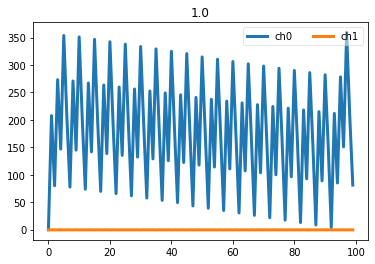

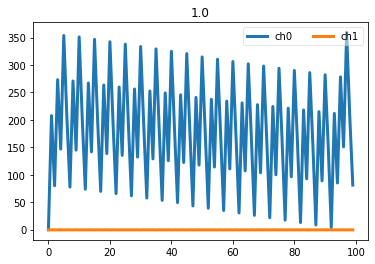

In [ ]:
show_timeseries(x0, title=y0)

### Show FLI plot

In [ ]:
# export
@delegates(sns.scatterplot, but=['data', 'x', 'y', 'hue', 'marker'])
def show_fli_plot(poinc_maps:np.ndarray=None, 
                  lbls:list=None, 
                  tdc:TSDataChaos=None,
                  **kwargs):
    "Show a scatter plot with the initial conditions (x0, y0) of each Poincare map in \
    `poinc_maps`, coloured with the labels given in `lbls`. If `poinc_maps` and `lbls` are \
    not set, the data will be taken from `tdc`'s x and y attributes.'"
    if tdc is not None:
        poinc_maps = tdc.x
        lbls = [str(x) for x in tdc.y]
    initial_conditions = poinc_maps[:,:,0]
    qux = pd.DataFrame(initial_conditions, columns=['x0', 'y0'])
    qux['class'] = lbls
    return sns.scatterplot(data=qux, x='x0', y='y0', hue='class', marker='.', **kwargs)

In [ ]:
mock_poinc_map = foo = np.random.randn(1000, 2, 100)
mock_lbls = random.choices(['chaotic', 'librational', 'rotational'], k=1000)

<AxesSubplot:xlabel='x0', ylabel='y0'>

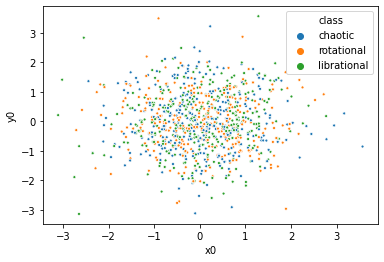

In [ ]:
# NOTE: These FLI plots are completely random
show_fli_plot(poinc_maps=mock_poinc_map, lbls=mock_lbls)

Pass kwargs arguments to sns.scatterplot

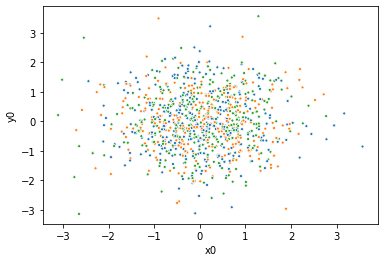

In [ ]:
show_fli_plot(poinc_maps=mock_poinc_map, lbls=mock_lbls, legend=False)

Test with a `TSDataChaos` object

In [ ]:
mock_tdc = TSDataChaos('foo')
mock_tdc.x = mock_poinc_map
mock_tdc.y = mock_lbls

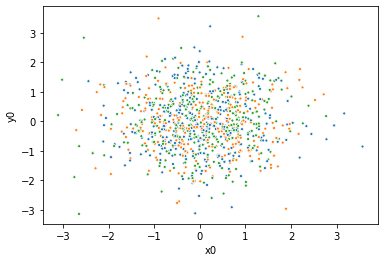

In [ ]:
show_fli_plot(tdc=mock_tdc, legend=None)